<a href="https://colab.research.google.com/github/imshivs/congressional-analysis/blob/master/Congressional_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# first some initial setup of libraries we will be using
import pandas as pd 
import json 
from urllib.request import urlopen 
import matplotlib.pyplot as plt 
import numpy as np
import statsmodels.api as sm
import seaborn as sns

In [ ]:
url="https://api.census.gov/data/2021/acs/acs1?get=NAME,B01003_001E,B06009_002E,B06009_004E,B06009_005E,B06009_006E,B19001_017E,B19001_001E,B19001_017E&for=congressional%20district:*&in=state:*"

# store the response of URL
response = urlopen(url)

# storing the JSON response from url in data
data_json = json.loads(response.read())
data_json.pop(0) # the first row of data is header information which we don't need, so pop removes that from the dataset.

# Hand populate the columns based on the variable descriptions census.gov documents here: https://api.census.gov/data/2021/acs/acs1/variables.html. Note they correspond back to the variable names I included in the URL above.
cols = ['District Name','Population','less than high school', 'high school', 'some college', 'bachelors degree','graduate or professional degree','Total Households', '$200k+', 'State code','district number']

acs_df = pd.DataFrame(data_json, columns = cols)

# time to do some basic cleanup of the data. We will need to extract the district number and state in a regular format so we can later join with the party data.
acs_df[['District', 'State']] = acs_df['District Name'].str.split(',', expand=True)
acs_df['district number'] = pd.to_numeric(acs_df['district number'])

acs_df['State'] = acs_df['State'].str.strip()

# Let's just keep the columns we need
acs_df = acs_df[['District Name','Population','less than high school', 'high school', 'some college', 'bachelors degree','graduate or professional degree','Total Households', '$200k+', 'district number', 'State']]

# take a look at the top results in the dataset
#acs_df.head()

In [ ]:
# converting columns to numeric
acs_df["Population"] = pd.to_numeric(acs_df["Population"])
acs_df["less than high school"] = pd.to_numeric(acs_df["less than high school"])
acs_df["high school"] = pd.to_numeric(acs_df["high school"])
acs_df["some college"] = pd.to_numeric(acs_df["some college"])
acs_df["bachelors degree"] = pd.to_numeric(acs_df["bachelors degree"])
acs_df["graduate or professional degree"] = pd.to_numeric(acs_df["graduate or professional degree"])
acs_df["Total Households"] = pd.to_numeric(acs_df["Total Households"])
#acs_df["Less than $10k"] = pd.to_numeric(acs_df["Less than $10k"])
acs_df['$200k+'] = pd.to_numeric(acs_df['$200k+'])

In [ ]:
# Data Wrangling 
acs_df['No college'] = acs_df['less than high school'] + acs_df['high school'] + acs_df['some college']
acs_df['Bachelors or Higher'] = acs_df['bachelors degree'] + acs_df['graduate or professional degree']  

In [ ]:
# Converting to percentages
acs_df['% of households over $200k'] = (100*acs_df['$200k+'])/acs_df['Total Households']
acs_df['% of population no college'] = (100*acs_df['No college'])/acs_df['Population']
acs_df['% of population bachelors or higher'] = (100*acs_df['Bachelors or Higher'])/acs_df['Population']
#acs_df.head()

In [ ]:
# read from the congressional data and put into a pandas dataframe
party_df = pd.read_csv("http://goodcsv.com/wp-content/uploads/2020/08/us-house-of-representatives-2020.csv", encoding = "ISO-8859-1")

# extract the district number from the data (it was in the format of 5th and we want that to just be 5) using a regular expression.
party_df['district number'] = party_df['District/Position'].str.extract('(\d+)')
party_df['district number'] = party_df['district number'].fillna(0)
party_df['district number'] = pd.to_numeric(party_df['district number'])
party_df['State'] = party_df['State/Territory']
party_df['State'] = party_df['State'].str.strip()
party_df['Party'] = party_df['Party'].str.strip() # remove extraneous whitespace

# Let's just keep the columns we need
party_df = party_df[['State', 'Party', "district number"]]

#party_df.head(5)

In [ ]:
# Merge is like a sql natural join. We are joining on the State and District numbers being the same between the two sets.
merged_df = pd.merge(acs_df, party_df, on=["State", "district number"])
final_merged_df = merged_df[['% of population bachelors or higher', '% of population no college', 'Party', '% of households over $200k']]
final_merged_df

,% of population bachelors or higher,% of population no college,Party,% of households over $200k
0,8.694363,39.313518,R,4.181493
1,7.760970,38.336229,R,3.977417
2,8.228020,40.059180,R,3.405150
3,6.690876,39.401184,R,3.797889
4,13.120593,42.306508,R,7.833083
...,...,...,...,...
430,13.074240,43.922245,R,9.440648
431,8.885035,40.402501,R,5.800476
432,8.280452,41.616942,R,5.337775
433,8.310563,40.565792,R,5.666663


# Hypothesis 

We believe education is a mediator variable that explains the relationship between income and party affiliation. This is our assumption because in every day life, education seems to be an important component in hiring, and therefore it has a direct relationship to how much one earns. We conducted an exploratory analysis in three steps to test whether education explains the process through which income and party affiliation are perhaps related.

# Part 1: The Relationship between Education and Party Affiliation

Based on the histograms below, both the most educated districts and the districts with high percentages without college degrees seem to have elected officials who are democrats. The districts with republican officials seem to fall somewhere in the middle in terms of level of education.

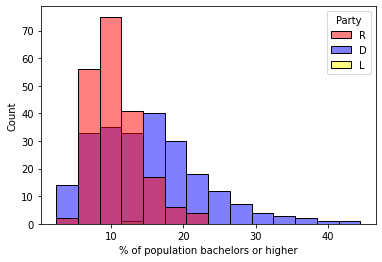

In [57]:
colors = {'R': '#FF0000', 'D': '#0000FF','L':'#FFFF00'}

sns.histplot(data=merged_df, x='% of population bachelors or higher', hue = 'Party',binwidth=3, palette = colors)

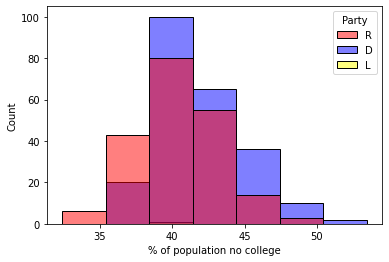

In [58]:
sns.histplot(data=merged_df, x= '% of population no college', hue = 'Party',binwidth=3, palette = colors)

# Part 2: The Relationship between Income and Education

The scatter plot belows shows a positive correlation between the proporation of the US population with a college education and the proportion of households earning 200K dollars or higher. We also see that in highly education districts where 20% or more households make over $200K, elected officials tend to be democrats.


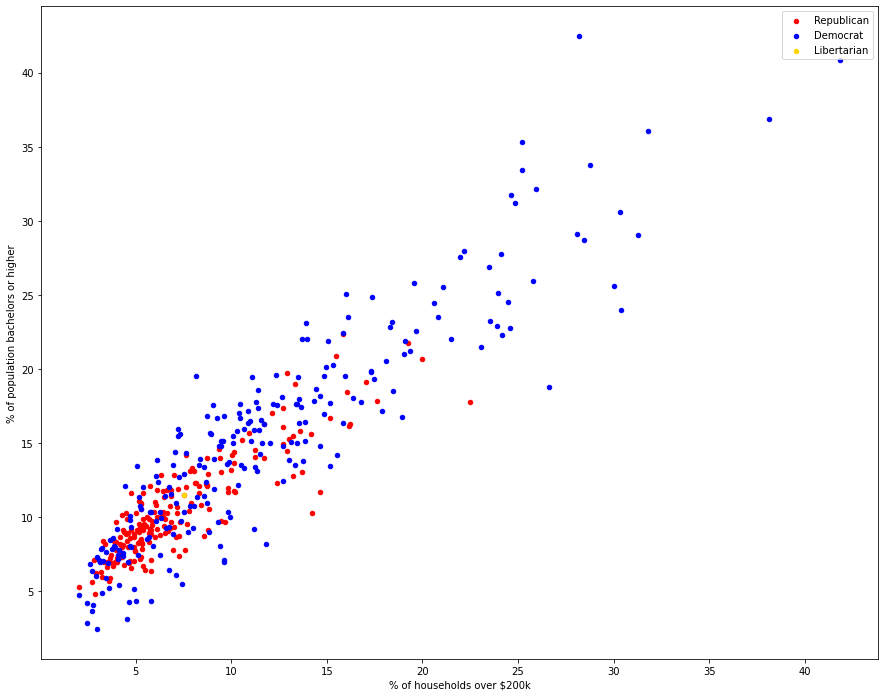

In [ ]:
#merged_df.where((merged_df['% of households over $200k'] <= 10) & merged_df['Party'].str.contains('R'))
R = merged_df.where((merged_df['Party'].str.contains('R')))
D = merged_df.where((merged_df['Party'].str.contains('D'))) 
L = merged_df.where((merged_df['Party'].str.contains('L')))

fig, ax = plt.subplots(figsize=(15, 12))
R.plot.scatter(x='% of households over $200k', y='% of population bachelors or higher', c='red',label='Republican', ax=ax)
D.plot.scatter(x='% of households over $200k', y='% of population bachelors or higher',c='blue',label='Democrat', ax=ax)
L.plot.scatter(x='% of households over $200k', y='% of population bachelors or higher',c='gold',label='Libertarian', ax=ax)

plt.legend()
plt.show()

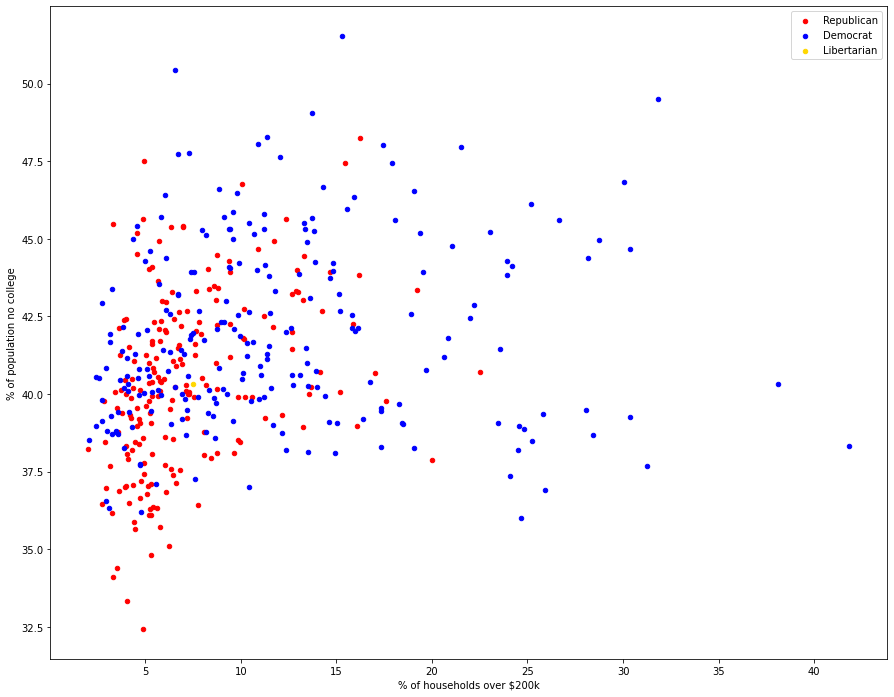

In [ ]:
R = merged_df.where([merged_df['Party'].str.contains('R') &]
D = merged_df[merged_df['Party'].str.contains('D')]
L = merged_df[merged_df['Party'].str.contains('L')]

fig, ax = plt.subplots(figsize=(15, 12))
R.plot.scatter(x='% of households over $200k', y='% of population no college', c='red',label='Republican', ax=ax)
D.plot.scatter(x='% of households over $200k', y='% of population no college',c='blue',label='Democrat', ax=ax)
L.plot.scatter(x='% of households over $200k', y='% of population no college',c='gold',label='Libertarian', ax=ax)

plt.legend()
plt.show()

# Part 3: A Closer Look at Income and Education

In the following scatter plots, we are increasing the level of education represented in each subset of our dataset. There seems to be positive correlation between income and education in all three cases. The relationship seems to be the strongest in the second scatterplot, where we see districts where 10% to 20% of the population has a college degree. 

In [ ]:
Less_than_ten_edu = merged_df.where((merged_df['% of population bachelors or higher'] <= 10))
Less_than_ten_edu_R = merged_df.where((merged_df['% of population bachelors or higher'] <= 10) & merged_df['Party'].str.contains('R'))
Less_than_ten_edu_D = merged_df.where((merged_df['% of population bachelors or higher'] <= 10) & merged_df['Party'].str.contains('D'))
Less_than_ten_edu_L = merged_df.where((merged_df['% of population bachelors or higher'] <= 10) & merged_df['Party'].str.contains('L'))

ten_to_twenty_edu = merged_df.where((merged_df['% of population bachelors or higher'] <= 20) & (merged_df['% of population bachelors or higher'] > 10))
ten_to_twenty_edu_R = merged_df.where((merged_df['% of population bachelors or higher'] <= 20) & (merged_df['% of population bachelors or higher'] > 10) & merged_df['Party'].str.contains('R'))
ten_to_twenty_edu_D = merged_df.where((merged_df['% of population bachelors or higher'] <= 20) & (merged_df['% of population bachelors or higher'] > 10) & merged_df['Party'].str.contains('D'))
ten_to_twenty_edu_L = merged_df.where((merged_df['% of population bachelors or higher'] <= 20) & (merged_df['% of population bachelors or higher'] > 10) & merged_df['Party'].str.contains('L'))

twenty_to_thirty_edu = merged_df.where((merged_df['% of population bachelors or higher'] <= 30) & (merged_df['% of population bachelors or higher'] > 20))
twenty_to_thirty_edu_R = merged_df.where((merged_df['% of population bachelors or higher'] <= 30) & (merged_df['% of population bachelors or higher'] > 20) & merged_df['Party'].str.contains('R'))
twenty_to_thirty_edu_D = merged_df.where((merged_df['% of population bachelors or higher'] <= 30) & (merged_df['% of population bachelors or higher'] > 20) & merged_df['Party'].str.contains('D'))
twenty_to_thirty_edu_L = merged_df.where((merged_df['% of population bachelors or higher'] <= 30) & (merged_df['% of population bachelors or higher'] > 20) & merged_df['Party'].str.contains('L'))

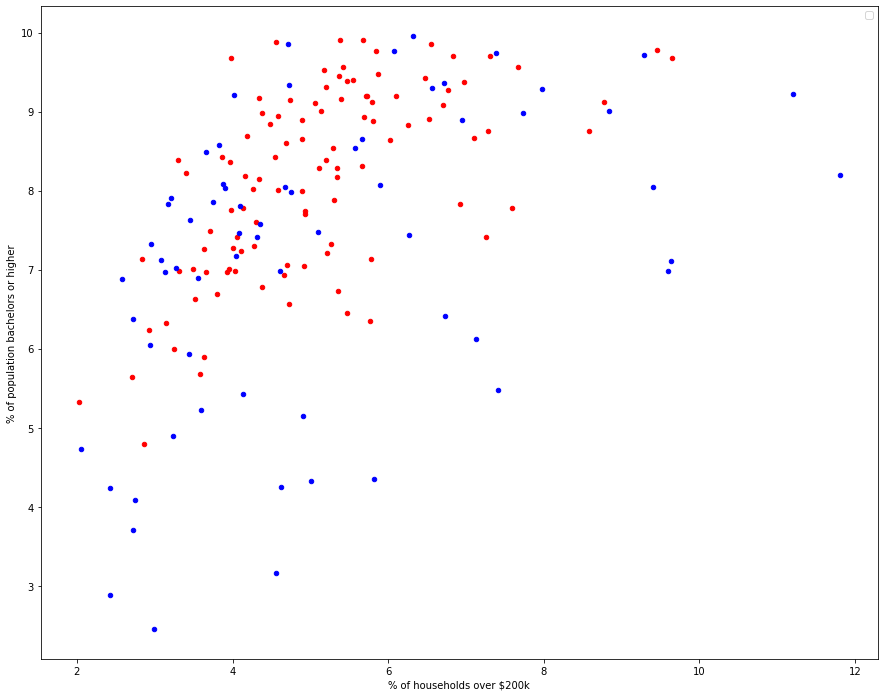

In [ ]:
fig, ax = plt.subplots(figsize=(15, 12))
Less_than_ten_edu_R.plot.scatter(x='% of households over $200k', y='% of population bachelors or higher', c='red', ax=ax)
Less_than_ten_edu_D.plot.scatter(x='% of households over $200k', y='% of population bachelors or higher', c='blue', ax=ax)
Less_than_ten_edu_L.plot.scatter(x='% of households over $200k', y='% of population bachelors or higher', c='yellow', ax=ax)

#sns.regplot(Less_than_ten['% of households over $200k'],Less_than_ten['% of population bachelors or higher'],ax=ax)

plt.legend()
plt.show()

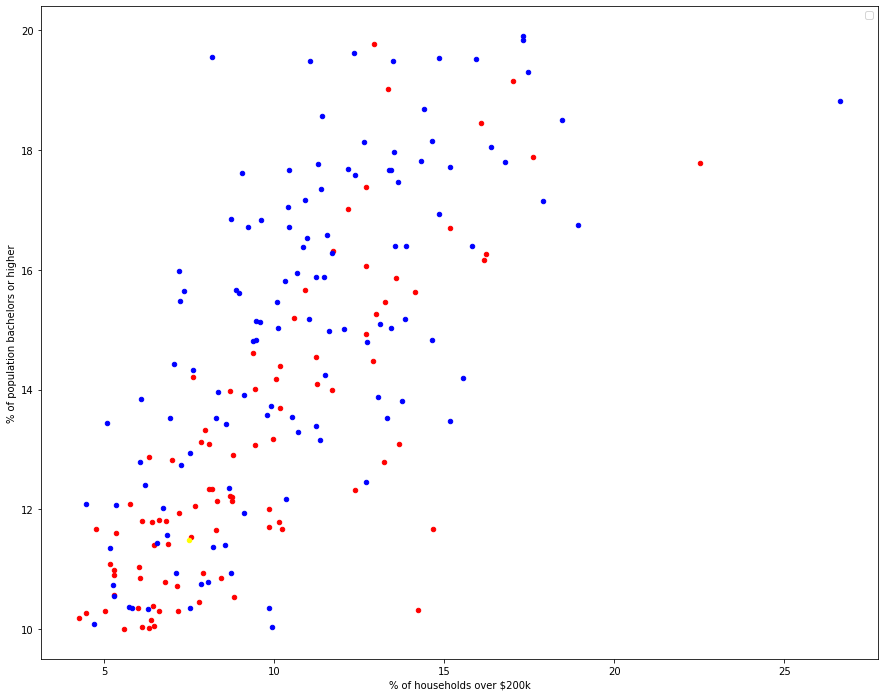

In [ ]:
fig, ax = plt.subplots(figsize=(15, 12))
ten_to_twenty_edu_R.plot.scatter(x='% of households over $200k', y='% of population bachelors or higher', c='red', ax=ax)
ten_to_twenty_edu_D.plot.scatter(x='% of households over $200k', y='% of population bachelors or higher', c='blue', ax=ax)
ten_to_twenty_edu_L.plot.scatter(x='% of households over $200k', y='% of population bachelors or higher', c='yellow', ax=ax)


plt.legend()
plt.show()

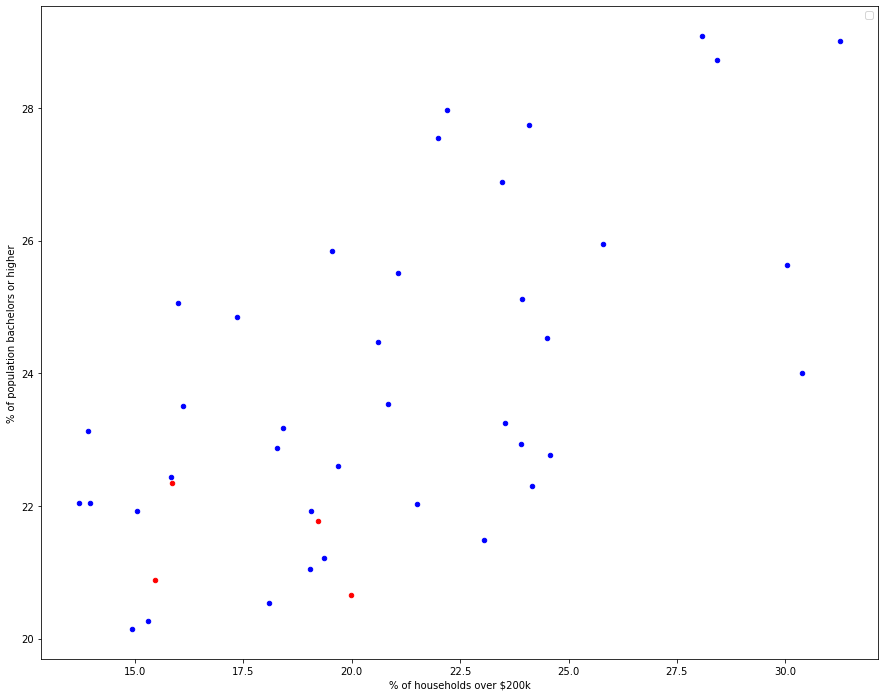

In [ ]:

fig, ax = plt.subplots(figsize=(15, 12))
twenty_to_thirty_edu_R.plot.scatter(x='% of households over $200k', y='% of population bachelors or higher', c='red', ax=ax)
twenty_to_thirty_edu_D.plot.scatter(x='% of households over $200k', y='% of population bachelors or higher', c='blue', ax=ax)
twenty_to_thirty_edu_L.plot.scatter(x='% of households over $200k', y='% of population bachelors or higher', c='yellow', ax=ax)

plt.legend()
plt.show()


# Conclusion

Education seems to be correlated with income and it also seems to have some relationship with party affiliation. In order to better understand the relationship between these three variables, it would he helpful to acquire data on individual or household income, as opposed to the count of individuals who make within a certain range of income. In addition, in order to prove or disprove our hypothesis, we would need to condut statistical tests measuring significance.